# Make PCA assessment on the chemical data

The data has been pre-processed and transformed from the `00_build_interim.ipynb` notebook. The PCA will be performed on selected chemical features from the resulting data set.

## Read the processed data

In [2083]:
# read the processed data with multiple header rows
import pandas as pd
master = pd.read_csv("../data/processed/master_pollution_rank.csv", 
                     header=[0, 1, 2], index_col=0)
master.head()

block      chemical                                                          \
subblock        raw                                                           
var         1234TCB   1245TCB     Al     As        Bi     Ca      Cd     Co   
StationID                                                                     
A10        0.835583  0.775732   3041  1.939  18.45000  28170  0.2950  2.723   
A23        0.639983  0.697265   4483  2.512  17.03000  42110  0.3986  4.009   
A27        0.451838  0.815149  13620  2.759   0.05370  41610  0.2180  6.273   
A28        0.224379  0.483363  12750  2.609   0.06617  33280  0.1197  5.824   
A29        0.299715  0.695356  23740  3.735   0.15290  40450  0.1536  9.618   

block                     ...                                    pollution  \
subblock                  ...      logz           sumreal_by_logz_chemical   
var            Cr     Cu  ...     ppDDE total_PCB                  SumReal   
StationID                 ...                                                
A10         8.766  17.64  ... -0.343200 -0.397416                 3.862263   
A23        10.850  17.28  ...  0.137696  0.365410                -0.211291   
A27        21.080  25.00  ...  0.149458  0.442485               -12.974650   
A28        18.700  24.07  ...  0.404618 -0.504533               -12.710383   
A29        44.370  44.72  ...  0.230192  0.256692               -14.827890   

block                                                                   \
subblock                                               2006_rank         
var          Quality SumReal_Shuffled Quality_Shuffled      Rank  rank   
StationID                                                                
A10           medium         4.351134        reference      54.0  14.0   
A23           medium         4.079811           medium      79.0  38.0   
A27        reference       -10.703442           medium      93.0  73.0   
A28        reference         0.124538           medium      92.0  69.0   
A29        reference         8.446216           medium      99.0  93.0   

block                         
subblock                      
var          Quality SumReal  
StationID                     
A10        reference    14.0  
A23           medium    38.0  
A27           medium    73.0  
A28           medium    69.0  
A29         degraded    93.0  

[5 rows x 107 columns]

## Import the PCA assessment module
A
Use the `%load_ext autoreload` and `autoreload 2` magic commands to automaticaaly load the updates that would be made to the imported modules.

In [2084]:
# auto-update for editing modules
%load_ext autoreload
%autoreload 2

from ecoindex import pca_assessment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use the `pca_assessment_module` to perform ordinal PCA assessment on the chemical data.

In [2085]:
# do a quick PCA assessment on the chemical data
result_raw = pca_assessment.pca_chemical_assessment(
    master,
    chemical_block="chemical",
    subblock="logz",
    n_components=None,
    standardize=False
)

result_raw.loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
var,,,,,,,,,,,,,,,,,,,,,
1234TCB,0.061054,-0.015634,0.046888,0.250382,0.189818,0.718098,-0.390569,0.091408,0.330294,-0.122517,...,-0.036590,-0.075989,0.024948,-0.012168,0.023305,-0.012729,0.034314,-0.023939,0.015145,-0.008170
1245TCB,0.102547,0.365677,0.094866,-0.221955,0.013789,-0.044031,-0.040276,-0.027920,0.092854,0.175778,...,-0.404878,0.012654,-0.028646,-0.091764,-0.169786,-0.017001,0.086857,0.022567,0.009338,-0.051205
Al,0.247804,-0.025925,-0.190998,0.036544,0.174833,-0.141217,-0.055491,-0.200387,0.031842,-0.009837,...,-0.098176,-0.097203,-0.128081,-0.245825,-0.009958,0.022331,-0.118574,-0.196093,0.435182,0.639991
As,0.135315,-0.144949,-0.057775,-0.215925,-0.100881,-0.063023,0.242713,0.376177,0.606900,0.267999,...,0.009469,-0.014871,-0.098032,-0.123883,0.183811,0.024729,-0.056745,-0.103426,-0.000803,-0.010838
Bi,-0.146367,0.260889,-0.035830,0.327371,-0.107171,-0.140939,0.010870,-0.136464,0.359211,-0.216267,...,-0.013558,0.110221,-0.144982,0.123191,-0.147235,-0.009909,-0.602367,0.158646,-0.108018,0.040880


## Import the chemical weights module for weighted PCA

The weights for different chemical types are defined in the `chemical_weights` module. These weights will be used in the PCA assessment to prioritize certain chemical types over others. 

Have a look at the weights of the first columns in the chemical data.

In [2086]:
# Inspect weights for variables in the chemical block and rerun weighted PCA
from ecoindex.chemical_weights import (
    build_weights_for_columns,
    VARIABLE_TYPE_BY_NAME,
    TYPE_WEIGHTS,
    configure_type_weights,
)
from ecoindex import pca_assessment
import pandas as pd

# Columns in use for the PCA call above
chem_cols = pca_assessment.get_block(master, "chemical", "logz").columns

# 1) Default weights based on current module settings
default_weight_map = build_weights_for_columns(chem_cols)

# 2) Customize type weights inline (override selected types only)
#    Merge with existing TYPE_WEIGHTS so unspecified types keep their defaults
new_type_weights = {
    "Trace Metal (pollutant)": 3.0,
    "Trace Metal_Sb (pollutant)": 10.0,  # Highest priority: toxic metals
    "Trace Metal_Bi (pollutant)": 1.0,  # Highest priority: toxic metals
    "Hydrocarbon pollutant": 3.0,        # Highest priority: petroleum/chlorobenzenes
    "organochlorine pesticide": 3.0,     # Highest priority: POPs
    "Sum of all PCBs": 3.0,              # Highest priority: PCBs
    "Binding agent": 3.0,               # Medium priority: affects bioavailability
    "Earth element (nontoxic)": 1.5   # Lowest priority: background elements
}
merged_type_weights = {**new_type_weights}
custom_weight_map = build_weights_for_columns(chem_cols, type_weights=merged_type_weights)

# Preview: variable -> (type, default_w, custom_w) for the first 10 variables
names = list(chem_cols)[:10]
rows = []
for name in names:
    vtype = VARIABLE_TYPE_BY_NAME.get(name, "Unclassified")
    w_def = default_weight_map.get(name, 1.0)
    w_cus = custom_weight_map.get(name, 1.0)
    rows.append((name, vtype, w_def, w_cus))
preview_df = pd.DataFrame(rows, columns=["variable", "type", "default_w", "custom_w"])\
             .assign(delta=lambda d: d.custom_w - d.default_w)
print(preview_df)

# Option A (one-off): use custom_weight_map directly in PCA below
# Option B (persistent): uncomment to update module defaults for the session
# configure_type_weights(new_type_weights, replace=False)

# For the rest of this notebook, use the custom map
weight_map = custom_weight_map

  variable                        type  default_w  custom_w  delta
0  1234TCB       Hydrocarbon pollutant        3.0       3.0    0.0
1  1245TCB       Hydrocarbon pollutant        3.0       3.0    0.0
2       Al    Earth element (nontoxic)       30.0       1.5  -28.5
3       As     Trace Metal (pollutant)        1.0       3.0    2.0
4       Bi  Trace Metal_Bi (pollutant)        0.0       1.0    1.0
5       Ca    Earth element (nontoxic)       30.0       1.5  -28.5
6       Cd     Trace Metal (pollutant)        1.0       3.0    2.0
7       Co     Trace Metal (pollutant)        1.0       3.0    2.0
8       Cr     Trace Metal (pollutant)        1.0       3.0    2.0
9       Cu     Trace Metal (pollutant)        1.0       3.0    2.0


Perform weighted PCA with the custom weights defined in the `chemical_weights` module.

In [2087]:
# Run PCA with weights applied
result_weighted = pca_assessment.pca_chemical_assessment(
    master,
    chemical_block="chemical",
    subblock="logz",
    standardize=False,
    apply_weights=True,
    custom_weights=weight_map,
)

result_weighted.loadings.head()

Applied variable weights - >=3.0: 23 vars, 2.0-<3.0: 0 vars, < 2.0: 7 vars, =1.0: 1 vars


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
var,,,,,,,,,,,,,,,,,,,,,
1234TCB,-0.063118,-0.000439,0.070085,0.157456,0.627971,-0.388032,-0.127949,0.570388,-0.083264,-0.095900,...,-0.006664,-0.019559,-0.051525,-0.007540,0.045315,-0.023672,-0.029913,-0.008448,-0.023251,-0.004115
1245TCB,-0.089828,0.381322,-0.024063,-0.223142,-0.051403,0.036459,-0.033950,0.039302,-0.134436,0.132988,...,0.252122,0.101718,-0.127639,-0.143322,-0.092093,0.012848,-0.056213,0.030602,-0.022598,-0.033902
Al,-0.174835,0.004981,-0.134572,0.105883,0.047323,0.163526,-0.083374,-0.076174,-0.123262,-0.071928,...,0.095211,0.159425,-0.040633,-0.254803,0.181448,-0.023675,0.146755,-0.184738,-0.321212,0.740386
As,-0.152504,-0.119136,-0.083194,-0.068625,-0.307894,0.176782,0.264629,0.603199,-0.070241,0.392290,...,-0.103380,0.079708,0.085001,0.002999,0.181239,-0.024226,0.035978,-0.082970,-0.022765,-0.009030
Bi,0.105852,0.146202,0.001535,0.191110,-0.046041,0.035971,-0.022748,0.093490,-0.051179,-0.051220,...,-0.021088,0.030282,0.083654,0.028088,-0.249992,-0.033506,0.851096,0.076071,0.303221,0.031980


Select the resulting PCs according to the pre-set and user-defined criteria.

The following factors will be considered when selecting the principal components (PCs):

- The initial weight set for each variable before implementing PCA.
- The number of totally considered loadings, which should be less than or equal to all raw variables.
- If preferring positive loadings over negative loadings.

In [2088]:
# Select PCs dominated by high-weight variables
from ecoindex import pca_assessment

selection_pos = pca_assessment.select_pcs_by_weighted_loadings(
    result_weighted,
    high_weight_threshold=5,
    loading_threshold=0.25,
    top_k_variables_per_pc=2,
    prefer_positive=True,
)

selected_pcs = selection_pos["selected_pcs"]
print(f"Total explained variance: {selection_pos['cumulative_explained_variance']}")
selected_pcs

Total explained variance: 0.6325165833599781


['PC1', 'PC2', 'PC4']

## Filter the selected PCs for pollution assessment

The selected PCs were selected based on the weighted variables that have high loadings in the PCs. 
The more high-weight variables a PC has with high loadings, the more likely it is to be selected for pollution assessment.

It does not count the variance explained by the selected PCs, which might include the PCs that have high loadings on important variables but explain little variance. And it might cause insufficient computation of the overall pollution assessment.

**Therefore, we can further filter the selected PCs based on their explained variance.**

In [2089]:
# prepare a explained_var_ratio_by_pcs
explained_var_ratio_by_pcs = pd.Series(
    result_weighted.explained_variance_ratio,
    index=result_weighted.loadings.columns
)
print(f"The explained variance ratios for the first 5 PCs are:\n{explained_var_ratio_by_pcs[:5]}")
print(f"The sum of explained variance ratios for all PCs is: {explained_var_ratio_by_pcs.sum()}")

The explained variance ratios for the first 5 PCs are:
PC1    0.409434
PC2    0.152665
PC3    0.095385
PC4    0.070418
PC5    0.038675
dtype: float64
The sum of explained variance ratios for all PCs is: 1.0


After filtering PCs, we want to drop more PCs by setting a total explained variance threshold.

For example, we can set a threshold of 80%, which means we want to keep the PCs that together explain at least 80% of the total variance, these PCs come from the previously selected PCs.

In [2090]:
def filter_selected_pcs_by_explained_variance(selected_pcs, explained_var_ratio_by_pcs, threshold=0.7):
    """
    Filter selected PCs based on cumulative explained variance threshold.
    
    Parameters:
    -----------
    selected_pcs : list
        List of selected PC names (e.g., ['PC1', 'PC2', 'PC4', 'PC5'])
    explained_var_ratio_by_pcs : pandas.Series
        Series with PC names as index and explained variance ratios as values
    threshold : float, default 0.7
        Cumulative explained variance threshold (0-1)
        
    Returns:
    --------
    tuple : (filtered_pcs, cumulative_variance)
        filtered_pcs : list of PC names that meet the threshold
        cumulative_variance : float, actual cumulative variance achieved
    """
    cumulative_variance = 0.0
    filtered_pcs = []
    
    for pc in selected_pcs:
        variance = explained_var_ratio_by_pcs.get(pc, 0)
        cumulative_variance += variance
        filtered_pcs.append(pc)
        
        if cumulative_variance >= threshold:
            break
            
    return filtered_pcs, cumulative_variance

<!-- <h3 style="color: blue;">Summary</h3> -->
### Summary

There are two parts in selecting PCs for the upcoming pollution assessment:
1. Implement Weighted PCA on all raw variables to decompose them into orthogonal PCs.
   - The weights on variables can influence the load of information(singular values) that each PC can explain.
2. Filter the PCs based on the loadings of high-weight variables and the total explained variance of the selected PCs.
   - A weight-threshold is set for considering loadings of high-weight variables, this weight was defined in the 
   **implementation** of the Weighted PCA.
   - A total explained variance threshold is set afterwords to shrink the number of finially selected PCs, keep right amount 
   of PCs and drop off low-information PCs.

In [2091]:
# Apply the function to the selected PCs
filtered_pcs, cumulative_variance = filter_selected_pcs_by_explained_variance(
    selected_pcs, explained_var_ratio_by_pcs, threshold=0.8
)

print(f"Filtered PCs: {filtered_pcs}")
print(f"Cumulative explained variance: {cumulative_variance:.4f}")

Filtered PCs: ['PC1', 'PC2', 'PC4']
Cumulative explained variance: 0.6325


# Sum the filtered PCs to get the pollution score(SumReal)

Add the scores of the **filtered PCs** to get the overall pollution assessment score.

Add the pollution assessment score to the master dataframe as a new block.

In [2092]:
import pandas as pd

from ecoindex.pca_assessment import compute_pollution_scores_with_labels
from ecoindex.dataframe_ops import merge_into_master_by_station

# Compute tidy pollution scores and labels from selected PCs
pollution_scores_df = compute_pollution_scores_with_labels(
    result_weighted,
    filtered_pcs,
    quantiles=(0.2, 0.8),
)

# Merge into the master as a new block/subblock
master_with_pollution = merge_into_master_by_station(
    master,
    pollution_scores_df,
    block_name="pollution",
    subblock_name="sumreal_by_logz_chemical",
)

# Display the new pollution block
pollution_block = master_with_pollution[("pollution", "sumreal_by_logz_chemical")]
print("\nPollution block added to master dataframe:")
print(pollution_block.head(10))


Pollution block added to master dataframe:
var          SumReal    Quality  SumReal_Shuffled Quality_Shuffled
StationID                                                         
A10         3.862263     medium          4.351134        reference
A23        -0.211291     medium          4.079811           medium
A27       -12.974650  reference        -10.703442           medium
A28       -12.710383  reference          0.124538           medium
A29       -14.827890  reference          8.446216           medium
A5          4.445049     medium        -15.799592        reference
A53         1.420402     medium          1.392168           medium
A58         0.000089     medium          3.001996           medium
A6        -13.709642  reference          1.309745           medium
A66        -1.424245     medium          3.862263         degraded


/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2226/1563920485.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  pollution_block = master_with_pollution[("pollution", "sumreal_by_logz_chemical")]


In [2093]:
# store the updated master dataframe as a CSV file
master_with_pollution.to_csv("../data/processed/master_example.csv", index=True)
# stop

## Validate the pollution assessment score

Do groupby aggregation on the raw or transformed chemical data to validate if:

- Higher pollution scores correspond to higher concentrations of harmful chemicals.
- Reference sites should averagely have lower concentrations of harmful chemicals than non-reference sites.

In [2094]:
# Check chemical concentrations by pollution quality that came from quantile cutoffs on the pollution scores
import pyperclip

def groupby_aggregation(df, groupby_block, groupby_subblock, groupby_var, 
                       agg_block, agg_subblock, agg_functions='mean'):
    """
    Perform groupby aggregation on a multi-level column DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The master dataframe with multi-level column structure (block, subblock, var)
    groupby_block : str
        Name of the block containing the groupby variable
    groupby_subblock : str
        Name of the subblock containing the groupby variable
    groupby_var : str
        Name of the variable to group by
    agg_block : str
        Name of the block to aggregate
    agg_subblock : str
        Name of the subblock to aggregate
    agg_functions : str or dict, default 'mean'
        Aggregation function(s) to apply. Can be:
        - String: single function like 'mean', 'sum', 'count', 'std'
        - Dict: mapping of column names to functions
        
    Returns:
    --------
    pandas.DataFrame : Aggregated results with groupby variable as index
    """
    # Extract the groupby column
    groupby_column = df[(groupby_block, groupby_subblock, groupby_var)]
    
    # Extract the block to aggregate
    agg_data = df[(agg_block, agg_subblock)]

    # Perform groupby aggregation
    if isinstance(agg_functions, str):
        # Single aggregation function
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    else:
        # Multiple aggregation functions
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    
    # Set index name
    result.index.name = f"{groupby_block}_{groupby_subblock}_{groupby_var}"
    
    return result

# Example usage: Group by pollution quality and aggregate chemical data
chemical_by_quality = groupby_aggregation(
    master_with_pollution,
    groupby_block="pollution",
    groupby_subblock="sumreal_by_logz_chemical", 
    groupby_var="Quality",
    agg_block="chemical",
    agg_subblock="raw",
    agg_functions="mean"
)

# print("Chemical concentrations by pollution quality:")
chemical_by_quality_transposed = chemical_by_quality.T.round(3)

# # Copy to clipboard
# latex_string = chemical_by_quality_transposed.to_latex()
# pyperclip.copy(latex_string)
# print("LaTeX table copied to clipboard!")
# print(custom_weight_map[-1])
chemical_by_quality_transposed

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2226/3397433374.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  agg_data = df[(agg_block, agg_subblock)]


pollution_sumreal_by_logz_chemical_Quality,degraded,medium,reference
var,,,
1234TCB,0.180,0.260,0.251
1245TCB,0.502,1.274,0.674
Al,2744.000,4812.823,9978.238
As,0.596,2.035,3.160
Bi,25.599,20.495,0.181
Ca,31409.524,30661.677,32416.333
Cd,0.413,0.336,0.481
Co,2.751,4.135,6.246
Cr,5.263,9.861,25.865


## Create shuffled pollution scores and labels for comparison

To test if the PERMANOVA and one-directional PERMANONA are significant, we can create shuffled pollution scores and labels for comparison.

In [2095]:
import numpy as np

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Get the Quality column
quality_column = master_with_pollution[('pollution', 'sumreal_by_logz_chemical', 'Quality')]

# Get the SumReal column
sumreal_column = master_with_pollution[('pollution', 'sumreal_by_logz_chemical', 'SumReal')]

# Shuffle the values
shuffled_quality = quality_column.values.copy()
shuffled_sumreal = sumreal_column.values.copy()
np.random.shuffle(shuffled_sumreal)
np.random.shuffle(shuffled_quality)

# Update the Quality column in place
master_with_pollution[('pollution', 'sumreal_by_logz_chemical', 'SumReal_Shuffled')] = shuffled_sumreal
master_with_pollution[('pollution', 'sumreal_by_logz_chemical', 'Quality_Shuffled')] = shuffled_quality

print("Quality labels have been shuffled randomly.")
print(f"Original order (first 10): {quality_column.head(10).tolist()}")
print(f"Shuffled order (first 10): {shuffled_quality[:10].tolist()}")

Quality labels have been shuffled randomly.
Original order (first 10): ['medium', 'medium', 'reference', 'reference', 'reference', 'medium', 'medium', 'medium', 'reference', 'medium']
Shuffled order (first 10): ['reference', 'medium', 'medium', 'medium', 'medium', 'reference', 'medium', 'medium', 'medium', 'degraded']


/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2226/3635741863.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  pollution_data = master_with_pollution[('pollution', 'sumreal_by_logz_chemical')]


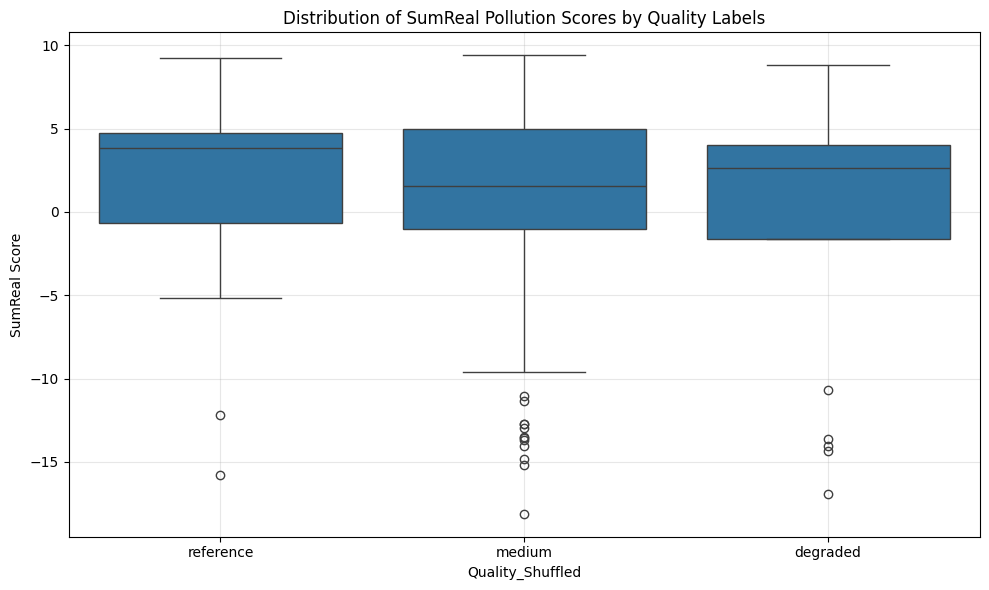

In [2096]:
import seaborn as sns

import matplotlib.pyplot as plt

# Visualize the distribution of SumReal pollution scores by Quality labels using seaborn
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Extract the pollution data
pollution_data = master_with_pollution[('pollution', 'sumreal_by_logz_chemical')]

# Create a dataframe for seaborn plotting
plot_data = pd.DataFrame({
    'SumReal': pollution_data['SumReal'],
    'Quality_Shuffled': pollution_data['Quality_Shuffled']
})

# Create box plot with seaborn
sns.boxplot(data=plot_data, x='Quality_Shuffled', y='SumReal', ax=ax)

ax.set_title('Distribution of SumReal Pollution Scores by Quality Labels')
ax.set_xlabel('Quality_Shuffled')
ax.set_ylabel('SumReal Score')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Check the chemical concentration distributions in the original ranked sites

In the original chemical data, there was a ranking of sites based on their pollution levels, which was done in around 2006.

We can **check the chemical concentration distributions in these ranked sites** to see if the ranking is consistent with the pollution assessment scores we calculated.

In [2097]:
original_rank = pd.read_excel("/Users/gufeng/Downloads/site_rank_test.xlsx")
original_rank.columns = ["StationID", "Rank"]
original_rank.head(10)

original_rank = original_rank.sort_values(by="Rank")
original_rank['SumReal'] = range(1, len(original_rank) + 1)
original_rank['Quality'] = original_rank.apply(lambda x: 'reference' if x['SumReal'] <= 20 else ('medium' if x['SumReal'] <= 80 else 'degraded'), axis=1)
original_rank

,StationID,Rank,SumReal,Quality
17,S81,21,1,reference
4,S72,22,2,reference
0,S70,23,3,reference
1,S74,40,4,reference
2,S53,43,5,reference
...,...,...,...,...
92,DJC2,99,96,degraded
95,S10,100,97,degraded
98,S27,100,98,degraded
97,UJC1,100,99,degraded


In [2098]:
# merge the original rank into the master_with_pollution dataframe
master_with_rank = merge_into_master_by_station(
    master_with_pollution,
    original_rank.set_index("StationID"),
    block_name="pollution",
    subblock_name="2006_rank"
)

# Display the new rank block
rank_block = master_with_rank[('pollution', '2006_rank')]
print("\nOriginal rank block added to master dataframe:")
print(rank_block.head(10))


Original rank block added to master dataframe:
var        Rank  rank    Quality  SumReal
StationID                                
A10        54.0  14.0  reference     14.0
A23        79.0  38.0     medium     38.0
A27        93.0  73.0     medium     73.0
A28        92.0  69.0     medium     69.0
A29        99.0  93.0   degraded     93.0
A5         54.0  15.0  reference     15.0
A53        92.0  71.0     medium     71.0
A58        90.0  66.0     medium     66.0
A6         94.0  78.0     medium     78.0
A66        64.0  21.0     medium     21.0


/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2226/563706623.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  rank_block = master_with_rank[('pollution', '2006_rank')]


In [2099]:
# Group by original rank quality and aggregate chemical data
chemical_by_original_quality = groupby_aggregation(
    master_with_rank,
    groupby_block="pollution",
    groupby_subblock="2006_rank", 
    groupby_var="Quality",
    agg_block="chemical",
    agg_subblock="raw",
    agg_functions="mean"
)

# Display the results
chemical_by_original_quality_transposed = chemical_by_original_quality.T.round(3)
print("Chemical concentrations by original rank quality:")
chemical_by_original_quality_transposed

Chemical concentrations by original rank quality:


/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2226/3397433374.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  agg_data = df[(agg_block, agg_subblock)]


pollution_2006_rank_Quality,degraded,medium,reference
var,,,
1234TCB,0.208,0.251,0.207
1245TCB,2.617,0.650,0.275
Al,9611.150,4787.067,3126.150
As,2.096,1.851,2.216
Bi,18.919,18.217,16.907
Ca,37511.650,32508.833,20900.700
Cd,0.523,0.335,0.145
Co,6.162,3.951,3.209
Cr,16.482,9.497,7.355


In [2100]:
# Fill NaN values in the Quality column with "medium"
master_with_rank[('pollution', '2006_rank', 'Quality')] = master_with_rank[('pollution', '2006_rank', 'Quality')].fillna("medium")

# Check if there are any remaining NaN values
remaining_nan = master_with_rank[('pollution', '2006_rank', 'Quality')].isna().sum()
print(f"Remaining NaN values after filling: {remaining_nan}")


Remaining NaN values after filling: 0


In [2101]:
master_with_rank['pollution', '2006_rank']['Quality'].unique()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2226/4014136636.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  master_with_rank['pollution', '2006_rank']['Quality'].unique()


array(['reference', 'medium', 'degraded'], dtype=object)

In [2102]:
master_with_rank.to_csv("../data/processed/master_pollution_rank.csv", index=True)